In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import recall_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
import lightgbm as lgb

 - __Import data, drop extra information and check count of target in class attribute__

In [4]:
url = "https://raw.githubusercontent.com/arimitramaiti/datasets/master/Classification/Skyserver_SQL2_27_2018%206_51_39%20PM.csv"
dataset = pd.read_csv(url, error_bad_lines=False, header=0)
dataset.drop(['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid'], axis=1, inplace=True)
dataset.shape
dataset.info()
dataset["class"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ra        10000 non-null  float64
 1   dec       10000 non-null  float64
 2   u         10000 non-null  float64
 3   g         10000 non-null  float64
 4   r         10000 non-null  float64
 5   i         10000 non-null  float64
 6   z         10000 non-null  float64
 7   class     10000 non-null  object 
 8   redshift  10000 non-null  float64
 9   plate     10000 non-null  int64  
 10  mjd       10000 non-null  int64  
 11  fiberid   10000 non-null  int64  
dtypes: float64(8), int64(3), object(1)
memory usage: 937.6+ KB


GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

 - __Create X and y datasets having independent vars and target var respectively__
 - __Apply Min max scaler on independent vars__
 - __Create 70:30 split for training and testing datasets__

In [5]:
X = dataset.drop(["class"], axis=1)
y = dataset["class"]

sc = MinMaxScaler()
X_scaled = sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, stratify=y, random_state=123)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7000, 11), (3000, 11), (7000,), (3000,))

# Random Search

 - __Instantiate a lgb classifier with Gradient-based One-Side Sampling__
 - __This is because we have a target having more than 2 outcomes__

In [6]:
estimator = lgb.LGBMClassifier(boosting_type ="goss", random_state=1)

 - __Declare a decimal range of learning rates__
 - __Declare a range of tree counts__
 - __Declare a set of max depth values__
 - __Declare a set of minimum child weight__
 - __Declare a set of sample proportions to be used in attribute sampling__
 - __Create dictionary which is a must for Random Search function__

In [7]:
learning_rate = np.arange(0.01,1,0.05)
n_estimators = np.arange(100, 500, 50)
max_depth = [2, 5, 10, 20, 30, 40, 50]
min_child_weight = [1,3,6]
colsample_bytree = [0.1, 0.5, 0.8, 1]
num_leaves = [300, 900, 1200]

param_grid = {'learning_rate': learning_rate,
              'n_estimators': n_estimators,
              'max_depth': max_depth,
              'min_child_weight': min_child_weight,
              'colsample_bytree': colsample_bytree,
              'num_leaves': num_leaves}

 - __Instantiate the RandomizedSearchCV object with accuracy as scoring metric__
 - __Push the parameter dictionary inside the object__

In [8]:
randomized_accuracy_fit = RandomizedSearchCV(estimator=estimator,
                                            param_distributions=param_grid,
                                            n_iter=50,
                                            scoring="accuracy",
                                            n_jobs=-1,
                                            refit=True,
                                            random_state=123,
                                            return_train_score=True,
                                            verbose=1,
                                            cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
                                            )

 - __Fit the RandomizedSearchCV object on X_train & y_train__

In [9]:
training_start = time.perf_counter()
randomized_accuracy_fit.fit(X_train, y_train)
training_end = time.perf_counter()
lgb_train_time = training_end-training_start
print("Time consumed for training: %4.3f seconds" % (lgb_train_time))

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.3s
C:\Users\Debjani\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.9min finished


Time consumed for training: 176.459 seconds


 - __Print the best score found by RandomizedSearchCV__
 - __Print the best model found by RandomizedSearchCV__

In [10]:
print(randomized_accuracy_fit.best_score_)
print(randomized_accuracy_fit.best_estimator_)

0.9901428571428573
LGBMClassifier(boosting_type='goss', class_weight=None, colsample_bytree=1,
               importance_type='split', learning_rate=0.51, max_depth=40,
               min_child_samples=20, min_child_weight=1, min_split_gain=0.0,
               n_estimators=450, n_jobs=-1, num_leaves=900, objective=None,
               random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


 - __Store the best model in an object__
 - __Create predictions from the best model__

In [11]:
best_estimator = randomized_accuracy_fit.best_estimator_
prediction_start = time.perf_counter()
y_pred = best_estimator.predict(X_test)
prediction_end = time.perf_counter()
lgb_prediction_time = prediction_end-prediction_start
print("Time consumed for prediction: %6.5f seconds" % (lgb_prediction_time))

Time consumed for prediction: 0.05930 seconds


 - __Calculate Accuracy and Recall Scores__
 - __Print the respective values__
 - __Create confusion matrix and print it using heatmap__

The accuracy score for the model is: 0.99
The recall score for the model is: 0.975


Text(91.68, 0.5, 'Actual')

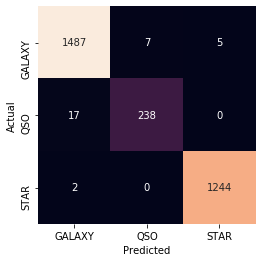

In [12]:
acc = round(accuracy_score(y_test, y_pred),3)
rec = round(recall_score(y_test, y_pred, average="macro"), 3)
print("The accuracy score for the model is: {}".format(acc))
print("The recall score for the model is: {}".format(rec))
met = confusion_matrix(y_test, y_pred)
sns.heatmap(met, square=True, annot=True, fmt="d", cbar=False, xticklabels=['GALAXY', 'QSO', 'STAR'], yticklabels=['GALAXY', 'QSO', 'STAR'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Bayesian Search

In [13]:
from bayes_opt import BayesianOptimization

 - __Create lower and upper bounds of hyper parameters to be searched for__

In [14]:
pbounds = {
    'learning_rate': (0.01, 1.0),
    'n_estimators': (100, 1000),
    'max_depth': (3,20),
    'childweight': (1, 6),
    'colsample': (0.1, 1.0),
    'num_leaves': (300, 1200),
    'gamma': (0, 5)}

 - __Declare a function which would use the hyper-paramter bounds in a lgb classifier__
 - __Compute mean accuracy of cross folds__

In [20]:
def lgboost_hyper_param(learning_rate,
                        n_estimators,
                        max_depth,
                        childweight,
                        colsample,
                        num_leaves,
                        gamma):
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    num_leaves = int(num_leaves)
    clf = lgb.LGBMClassifier(
        boosting_type ="goss",
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        colsample_bytree=colsample,
        min_child_weight=childweight,
        num_leaves=num_leaves,
        gamma=gamma)
    return np.mean(cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(10), scoring='accuracy'))

 - __Instantiate the BayesianOptimization object__
 - __First arguement is the function that declares a lgb classifier with certain set of hyper parameters__
 - __Second arguement is the set of hyper parameter bounds__

In [23]:
optimizer = BayesianOptimization(
    f=lgboost_hyper_param,
    pbounds=pbounds,
    random_state=1)

 - __Create 100 bayesian steps of optimization and 8 steps of random exploration__

In [24]:
training_start = time.perf_counter()
optimizer.maximize(n_iter=100, init_points=8, acq='ei')
training_end = time.perf_counter()
lgb_train_time = training_end-training_start
print("Time consumed for training: %4.3f seconds" % (lgb_train_time))

|   iter    |  target   | childw... | colsample |   gamma   | learni... | max_depth | n_esti... | num_le... |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.989    |  3.085    |  0.7483   |  0.000571 |  0.3093   |  5.495    |  183.1    |  467.6    |
|  2        |  0.9896   |  2.728    |  0.4571   |  2.694    |  0.425    |  14.65    |  284.0    |  1.09e+03 |
|  3        |  0.989    |  1.137    |  0.7034   |  2.087    |  0.5631   |  5.387    |  278.3    |  1.021e+0 |
|  4        |  0.9893   |  5.841    |  0.3821   |  3.462    |  0.8776   |  18.21    |  176.5    |  335.1    |
|  5        |  0.9896   |  1.849    |  0.8903   |  0.4917   |  0.4269   |  19.28    |  579.8    |  922.7    |
|  6        |  0.9897   |  2.578    |  0.7179   |  4.173    |  0.02811  |  15.75    |  990.0    |  973.3    |
|  7        |  0.99     |  2.402    |  0.8104   |  0.5161   |  0.4534   |  18.45    |  364.3    |  559.0    |
|  8      

|  45       |  0.9899   |  1.954    |  0.8855   |  0.4395   |  0.5318   |  19.26    |  113.3    |  1.169e+0 |
|  46       |  0.9893   |  1.894    |  0.1095   |  0.8502   |  0.3833   |  19.0     |  117.9    |  1.195e+0 |
|  47       |  0.9899   |  2.457    |  0.4093   |  0.3415   |  0.3103   |  4.219    |  108.5    |  1.195e+0 |
|  48       |  0.9889   |  4.868    |  0.5411   |  1.249    |  0.9845   |  4.237    |  101.8    |  1.195e+0 |
|  49       |  0.9894   |  4.113    |  0.597    |  1.507    |  0.932    |  19.71    |  109.3    |  330.0    |
|  50       |  0.9891   |  1.098    |  0.5716   |  3.882    |  0.3922   |  18.05    |  987.0    |  1.188e+0 |
|  51       |  0.9901   |  4.573    |  0.6298   |  0.2105   |  0.8949   |  3.07     |  111.1    |  316.3    |
|  52       |  0.989    |  3.036    |  0.8516   |  0.1811   |  0.7337   |  3.336    |  122.3    |  316.8    |
|  53       |  0.9887   |  5.344    |  0.3179   |  1.512    |  0.1335   |  19.87    |  102.9    |  313.5    |
|  54     

|  90       |  0.9901   |  4.561    |  0.683    |  0.8354   |  0.2857   |  19.5     |  143.7    |  1.197e+0 |
|  91       |  0.9891   |  1.861    |  0.6573   |  4.555    |  0.8321   |  19.04    |  107.5    |  1.19e+03 |
|  92       |  0.9896   |  2.219    |  0.9395   |  0.4472   |  0.3124   |  16.32    |  113.3    |  1.193e+0 |
|  93       |  0.9891   |  1.364    |  0.1503   |  3.888    |  0.9421   |  19.96    |  155.6    |  1.198e+0 |
|  94       |  0.9897   |  2.227    |  0.6173   |  0.3664   |  0.5339   |  4.236    |  105.1    |  1.189e+0 |
|  95       |  0.989    |  4.784    |  0.6352   |  3.766    |  0.863    |  19.96    |  116.3    |  308.6    |
|  96       |  0.9886   |  5.477    |  0.8999   |  4.994    |  0.7531   |  3.82     |  990.4    |  1.184e+0 |
|  97       |  0.9893   |  3.285    |  0.1058   |  2.034    |  0.6443   |  4.648    |  100.2    |  316.5    |
|  98       |  0.9889   |  2.66     |  0.7553   |  4.2      |  0.8795   |  18.45    |  110.1    |  1.196e+0 |
|  99     

 - __Print the best set of hyper parameter values__

In [25]:
best_params = optimizer.max['params']
print(best_params)

{'childweight': 3.9228104280950444, 'colsample': 0.6337031176054476, 'gamma': 3.986580139221042, 'learning_rate': 0.6022803491030518, 'max_depth': 3.2103487195710434, 'n_estimators': 104.72353569316859, 'num_leaves': 307.57145582504506}


In [26]:
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['learning_rate'] = round(best_params['learning_rate'],2)
best_params['gamma'] = round(best_params['gamma'],2)
best_params['colsample'] = round(best_params['colsample'],2)
best_params['childweight'] = int(best_params['childweight'])
best_params['num_leaves'] = int(best_params['num_leaves'])

In [27]:
print(best_params['max_depth'], best_params['n_estimators'], best_params['learning_rate'], best_params['gamma'], best_params['colsample'],
     best_params['childweight'], best_params['num_leaves'])

3 104 0.6 3.99 0.63 3 307


 - __Fit the best found model using the best found hyper parameter values__

In [28]:
best_bayesian_estimator = lgb.LGBMClassifier(boosting_type ="goss",
                                            max_depth=best_params['max_depth'],
                                            learning_rate=best_params['learning_rate'],
                                            n_estimators=best_params['n_estimators'],
                                            gamma=best_params['gamma'],
                                            colsample_bytree=best_params['colsample'],
                                            min_child_weight=best_params['childweight'],
                                            num_leaves=best_params['num_leaves'])

 - __Create predictions from the best found model__

In [29]:
y_pred_bayesian = best_bayesian_estimator.fit(X_train, y_train).predict(X_test)

 - __Calculate Accuracy and Recall Scores__
 - __Print the respective values__
 - __Create confusion matrix and print it using heatmap__

The accuracy score for the model is: 0.989
The recall score for the model is: 0.974


Text(91.68, 0.5, 'Actual')

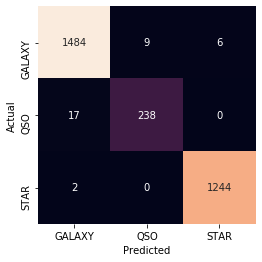

In [30]:
acc = round(accuracy_score(y_test, y_pred_bayesian),3)
rec = round(recall_score(y_test, y_pred_bayesian, average="macro"), 3)
print("The accuracy score for the model is: {}".format(acc))
print("The recall score for the model is: {}".format(rec))
met = confusion_matrix(y_test, y_pred_bayesian)
sns.heatmap(met, square=True, annot=True, fmt="d", cbar=False, xticklabels=['GALAXY', 'QSO', 'STAR'], yticklabels=['GALAXY', 'QSO', 'STAR'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

 - __Useful links__

https://github.com/fmfn/BayesianOptimization

https://aiinpractice.com/xgboost-hyperparameter-tuning-with-bayesian-optimization/
    
https://analyticsindiamag.com/implementing-bayesian-optimization-on-xgboost-a-beginners-guide/